1\. **Color-coded scatter plot**

Produce a scatter plot from a dataset with two categories.

* Write a function that generates a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and standard deviation. Set different values of the mean and stardand deviation between the two samples.
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below:

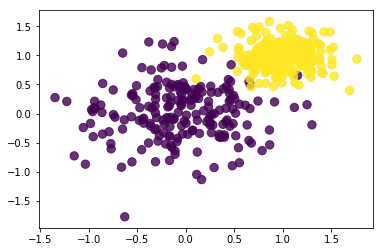

In [1]:
from IPython.display import Image
Image('two_categories_scatter_plot.png')

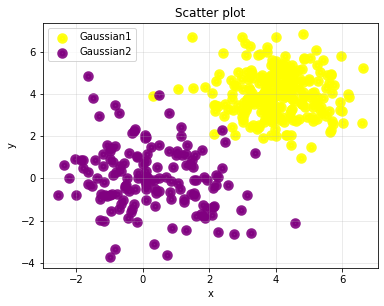

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def gauss_2d(N1,N2,mn1,mn2,std1,std2): 
    x=np.random.normal(loc=mn1, scale=std1, size=(N1,2))
    y=np.random.normal(loc=mn2, scale=std2, size=(N2,2))
    return x,y

x,y=gauss_2d(250,150,4.,0.,1.,1.5)
fig, ax = plt.subplots(figsize=(6, 4.5))
ax.scatter(x[:,0],x[:,1], marker='o', c='yellow', alpha=0.9, linewidths=4.5, label='Gaussian1')
ax.scatter(y[:,0],y[:,1], marker='o', c='purple', alpha=0.9, linewidths=4.5, label='Gaussian2')
ax.set_title('Scatter plot')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
ax.grid(alpha=0.3)



2\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following pickle file:
```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```
* Inspect the dataset, you'll find two variables (features)
* Convert the content to a Pandas Dataframe
* Clean the sample by selecting the entries (rows) with the absolute values of the variable "residual" smaller than 2
* Plot a Seaborn jointplot of "residuals" versus "distances", and use seaborn to display a linear regression. 

Comment on the correlation between these variables.

* Create manually (without using seaborn) the profile histogram for the "distance" variable; choose an appropriate binning.
* Obtain 3 numpy arrays:
  * `x`, the array of bin centers of the profile histogram of the "distance" variable
  * `y`, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * `err_y`, the standard deviation of the of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [123]:
#!wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/

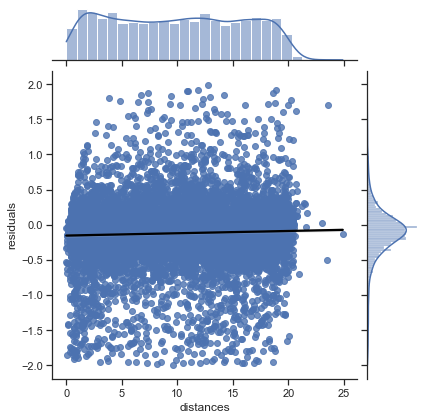

In [36]:
import pickle
import seaborn as sns

#Getting the data and displaying a seaborn joinplot for residuals vs distances 
infile=open('data/residuals_261.pkl', 'rb')
new=pickle.load(infile)
infile.close()

di=dict(new.item())
df=pd.DataFrame(di)

df=df[abs(df['residuals'])<2.] # for |residuals|<2 is considered

sns.set_theme(style='ticks')
p=sns.jointplot(x='distances', y='residuals', data=df,  kind='reg', joint_kws={'line_kws':{'color':'black'}})

# Correlation between variables:
# It seems to be a linear relation between the two variables, but the correlation of the two variables is almost zero 


Profile histogram for distance variable by hand:


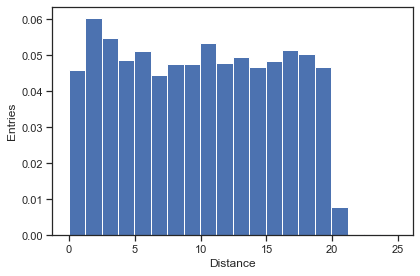

In [47]:
print('Profile histogram for distance variable by hand:')
fig, ax = plt.subplots()
h, bins, _ = plt.hist(df['distances'], bins=20, density=True, cumulative=False)

ax.set_xlabel('Distance')
ax.set_ylabel('Entries')
fig.tight_layout()

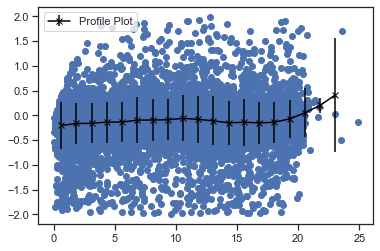

In [40]:
#array of bin centers
x = 0.5*(bins[1:] + bins[:-1])
y = np.zeros(x.size)
erry = np.zeros(x.size)

#y and e_rry arrays
y=np.array([df.loc[(df['distances'] >=bins[i]) & (df['distances'] <bins[i+1])]['residuals'].mean() for i in range(20)])
e_rry=np.array([df.loc[(df['distances'] >=bins[i]) & (df['distances'] <bins[i+1])]['residuals'].std() for i in range(20)])

#Plot the profile plot on top of the scatter plot
plt.scatter(df['distances'],df['residuals'])
plt.errorbar(x, y, e_rry, label='Profile Plot', linewidth=1.5 , color='black' , marker='x')
plt.legend()
plt.show()

3\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn):

* Fill a numpy array `x` of length N (with $N=\mathcal{O}(100)$) with a variable normally distributed, with a given mean and standard deviation
* Fill an histogram in pyplot taking proper care of the aesthetic:
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* For every element of `x`, create a gaussian with the mean corresponding to the element value and the standard deviation as a parameter that can be tuned. The standard deviation default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with `np.sum()`) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method. Superimpose the normalized sum of all gaussians to the first histogram.


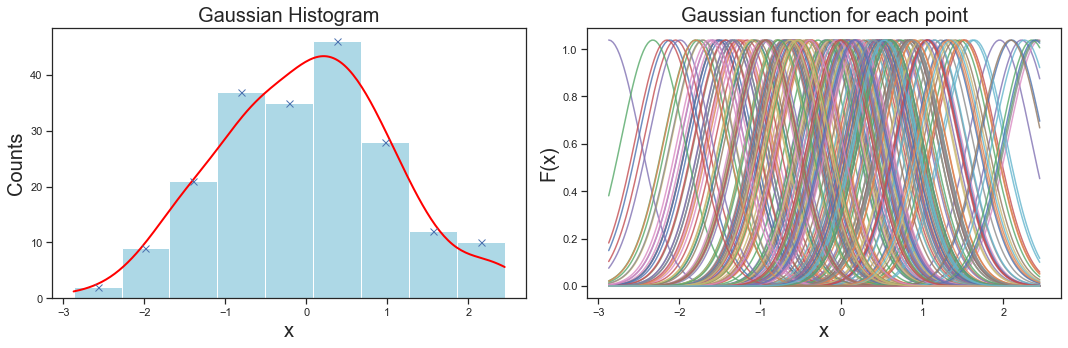

In [122]:
from scipy.integrate import trapz
from scipy.stats import norm

N = 200
x = np.array(np.random.normal(0, 1, N))
min_x = np.min(x)
max_x = np.max(x)
step = 10

fig,((ax1,ax2)) = plt.subplots(1,2,figsize=(15,5))
height, bins, __ = ax1.hist(x, bins=np.linspace(min_x, max_x, step), range=(min_x, max_x),color='lightblue', label='Histogram')

# display for each bin data points with error
centers = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins) - 1)])
height[height == 0] = None
poisson_err = 1 /np.sqrt(height)

ax1.errorbar(centers, height, yerr=poisson_err, label='Error', marker='x',markersize=7, lw = 0)
ax1.set_xlabel('x', fontsize = 20)
ax1.set_ylabel('Counts', fontsize = 20)                              
ax1.set_title('Gaussian Histogram', fontsize = 20)

# for Gaussian functions
sig = 1.06*x.std()*x.size**(-1/5)
xg = np.linspace(x.min(), x.max(), N)
gauss = np.zeros((N,N))

for i in range(N):    
    gauss[i] = norm.pdf(xg, x[i], sig)
    ax2.plot(xg, gauss[i], alpha = 0.8)

ax2.set_title('Gaussian function for each point', fontsize = 20)
ax2.set_xlabel('x', fontsize = 20)
ax2.set_ylabel('F(x)', fontsize = 20)

# KDE
data = np.nan_to_num(data)
sumg = np.sum(gauss, axis=0)
bin_width = bins[1] - bins[0]

area = trapz(y = sumg, x = xg)
int_hist = bin_width * sum(data[:])

ax1.plot(xg, sumg*int_hist/area, color = 'red', linewidth=2, label='KDE')
fig.tight_layout()
plt.show()